# Surface wave and receiver function - joint inversion

In [1]:
import bayesbay as bb
from bayesbay.discretization import Voronoi1D

from functools import partial
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, AutoLocator, FixedLocator
from disba import PhaseDispersion # install disba for forward modelling of dispersion curves
import pyhk  # Install pyhk for forward modelling of receiver functions 

In [2]:
np.random.seed(30)
np.seterr(all="ignore");

In [3]:
THICKNESS = np.array([10, 10, 15, 20, 20, 20, 20, 20, 0])
VS = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
VP_VS = 1.77
VP = VS * VP_VS
RHO = 0.32 * VP + 0.77

In [4]:
def initialize_vs(param, positions=None):
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    return sorted_vals

vs = bb.prior.UniformPrior(name="vs", 
                           vmin=[2.2, 2.8, 3.3, 4], 
                           vmax=[3.9, 4.6, 4.8, 5], 
                           position=[0, 20, 60, 150],
                           perturb_std=0.15)
vs.set_custom_initialize(initialize_vs)

voronoi = Voronoi1D(
    name="voronoi", 
    vmin=0,
    vmax=150,
    perturb_std=10,
    n_dimensions=None, 
    n_dimensions_min=4,
    n_dimensions_max=15,
    parameters=[vs], 
    birth_from='neighbour'
)
parameterization = bb.parameterization.Parameterization(voronoi)

### Surface wave

In [5]:
PERIODS = np.geomspace(3, 80, 20)
RAYLEIGH_STD = 0.02
LOVE_STD = 0.02

In [6]:
def forward_sw(state, wave='rayleigh', mode=0):
    voronoi = state["voronoi"]
    voronoi_sites = voronoi["discretization"]
    thickness = Voronoi1D.compute_cell_extents(voronoi_sites)
    vs = voronoi["vs"]
    vp = vs * VP_VS
    rho = 0.32 * vp + 0.77
    pd = PhaseDispersion(thickness, vp, vs, rho)
    d_pred = pd(PERIODS, mode=mode, wave=wave).velocity
    return d_pred

forward_rayleigh = partial(forward_sw, wave='rayleigh', mode=0)
forward_love = partial(forward_sw, wave='love', mode=0)

In [7]:
pd = PhaseDispersion(THICKNESS, VP, VS, RHO)
rayleigh = pd(PERIODS, mode=0, wave="rayleigh").velocity
love = pd(PERIODS, mode=0, wave="love").velocity
rayleigh_obs = rayleigh + np.random.normal(0, RAYLEIGH_STD, rayleigh.size)
love_obs = love + np.random.normal(0, LOVE_STD, love.size)

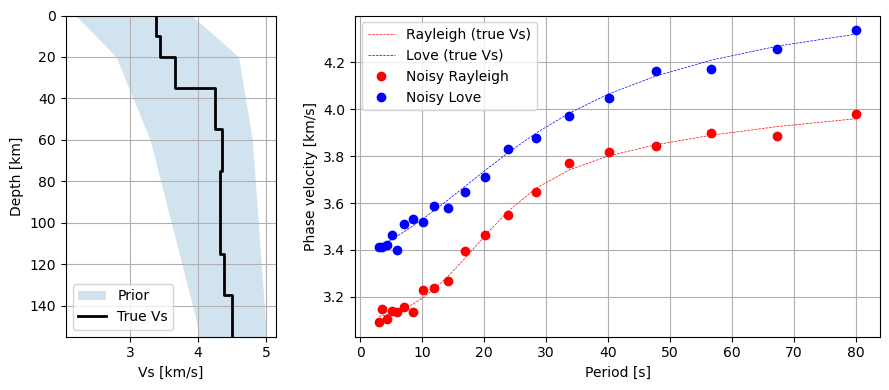

In [8]:
depth_prior = np.linspace(0, 200)
vmin_prior, vmax_prior = vs.get_vmin_vmax(depth_prior)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 2.5]})
ax1.fill_betweenx(depth_prior, vmin_prior, vmax_prior, alpha=0.2, label='Prior')
Voronoi1D.plot_tessellation(THICKNESS, 
                            VS, 
                            label='True Vs', 
                            ax=ax1, 
                            color='k', 
                            lw=2, 
                            input_type='extents')
ax1.set_xlabel('Vs [km/s]')
ax1.set_ylabel('Depth [km]')
ax1.set_ylim(np.cumsum(THICKNESS)[-1] + max(THICKNESS), 0)
ax1.grid()
ax1.legend()

ax2.plot(PERIODS, rayleigh, 'r--', label='Rayleigh (true Vs)', lw=0.5)
ax2.plot(PERIODS, love, 'b--', label='Love (true Vs)', lw=0.5)
ax2.plot(PERIODS, rayleigh_obs, 'ro', label='Noisy Rayleigh')
ax2.plot(PERIODS, love_obs, 'bo', label='Noisy Love')
ax2.set_xlabel('Period [s]')
ax2.set_ylabel('Phase velocity [km/s]')
ax2.grid()
ax2.legend()

plt.tight_layout(w_pad=2)
plt.show()

### Receiver function

In [9]:
T_SHIFT = 5
T_DURATION = 25
T_SAMPLING_INTERVAL = 0.1
GAUSS = 1
RAY_PARAM_S_KM = 0.07
RF_STD = 0.015

In [10]:
def forward_rf(state):
    voronoi = state["voronoi"]
    voronoi_sites = voronoi["discretization"]
    thickness = Voronoi1D.compute_cell_extents(voronoi_sites)
    vs = voronoi["vs"]
    return pyhk.rfcalc(
        ps=0, 
        thik=thickness, 
        beta=vs, 
        kapa=np.ones((len(vs),))*VP_VS,
        p=RAY_PARAM_S_KM, 
        duration=T_DURATION, 
        dt=T_SAMPLING_INTERVAL, 
        shft=T_SHIFT, 
        gauss=GAUSS
    )

In [11]:
rf = pyhk.rfcalc(
    ps=0, 
    thik=THICKNESS, 
    beta=VS, 
    kapa=np.ones((len(VS),))*VP_VS,
    p=RAY_PARAM_S_KM, 
    duration=T_DURATION, 
    dt=T_SAMPLING_INTERVAL, 
    shft=T_SHIFT, 
    gauss=GAUSS
)
rf_obs = rf + np.random.normal(0, RF_STD, rf.size)

RF_TIMES = np.arange(len(rf_obs)) * T_SAMPLING_INTERVAL - T_SHIFT

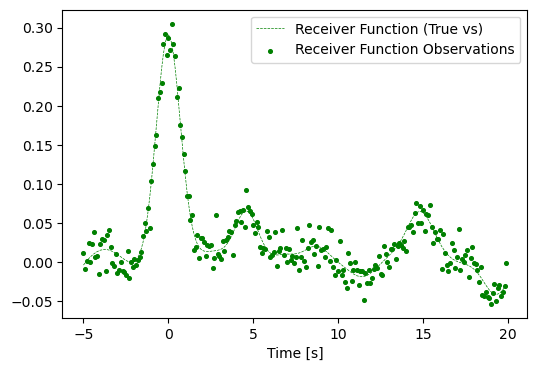

In [12]:
_, ax = plt.subplots(figsize=(6, 4))

ax.plot(RF_TIMES, rf, 'g--', label="Receiver Function (True vs)", lw=0.5)
ax.scatter(RF_TIMES, rf_obs, label="Receiver Function Observations", s=7, c="g")
ax.set_xlabel("Time [s]")
ax.legend()

## Sample with BayesBay

In [13]:
target_rayleigh = bb.likelihood.Target("rayleigh", 
                            rayleigh_obs, 
                            std_min=0.001, 
                            std_max=0.1, 
                            std_perturb_std=0.002)
target_love = bb.likelihood.Target("love", 
                        love_obs, 
                        std_min=0.001, 
                        std_max=0.1, 
                        std_perturb_std=0.002)
target_rf = bb.likelihood.Target("rf", 
                      rf_obs, 
                      std_min=0.001, 
                      std_max=0.1, 
                      std_perturb_std=0.002)

targets = [target_rayleigh, target_love, target_rf]
fwd_functions = [forward_rayleigh, forward_love, forward_rf]

log_likelihood = bb.likelihood.LogLikelihood(targets, fwd_functions)

In [14]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood,
    n_chains=24
)
inversion.run(
    sampler=bb.samplers.SimulatedAnnealing(temperature_start=3), 
    n_iterations=600_000, 
    burnin_iterations=150_000, 
    save_every=150,
    verbose=False
)

## Plot results

In [15]:
results = inversion.get_results(concatenate_chains=True)


sampled_voronoi_nuclei = results["voronoi.discretization"]
sampled_thickness = [Voronoi1D.compute_cell_extents(n) for n in sampled_voronoi_nuclei]
sampled_vs = results["voronoi.vs"]
interp_depths = np.linspace(0, 160, 160)
statistics_vs = Voronoi1D.get_tessellation_statistics(
    sampled_thickness, sampled_vs, interp_depths, input_type="extents"
)


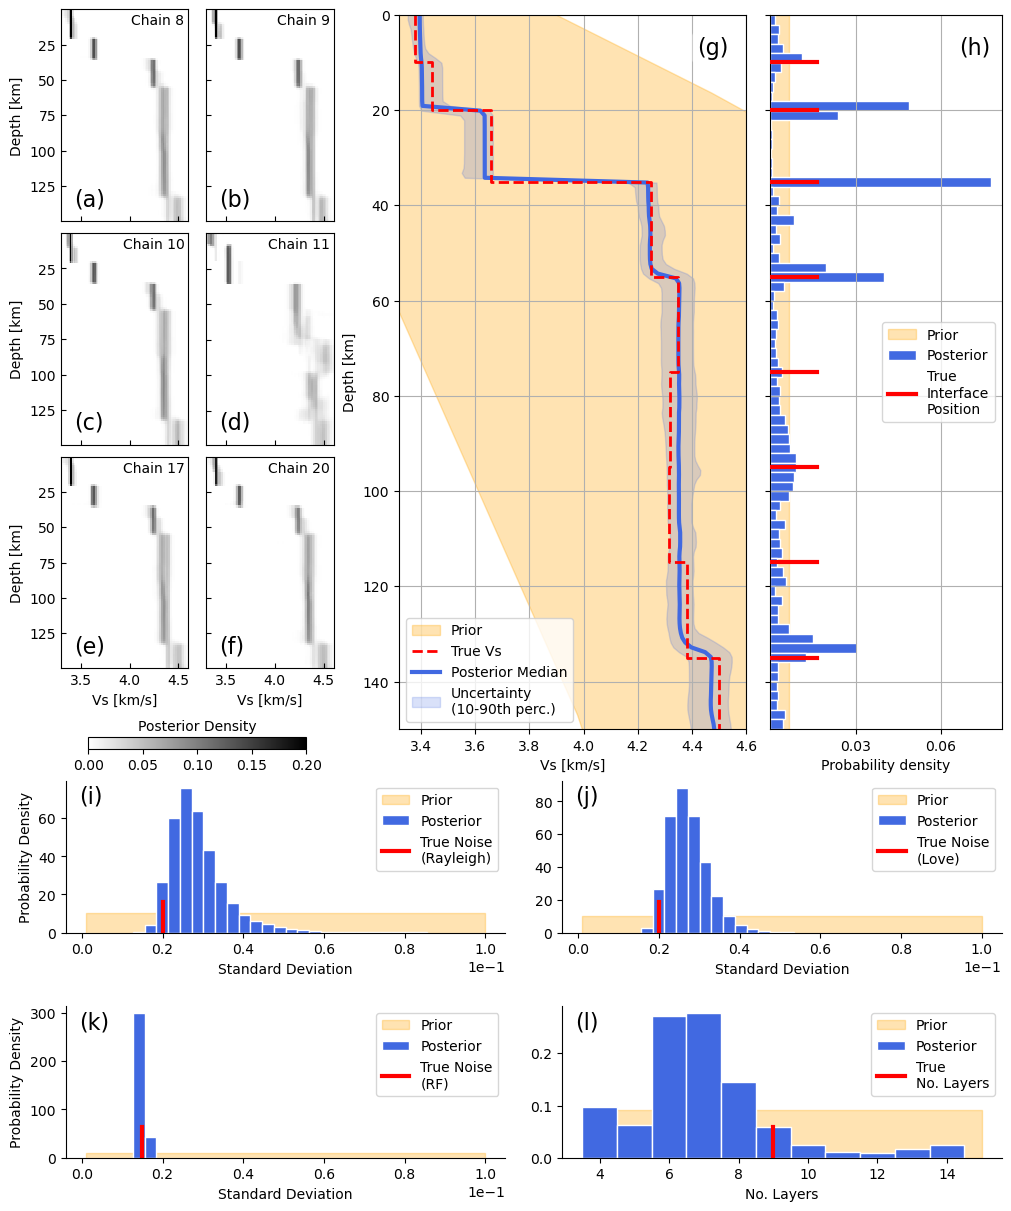

In [16]:
fig = plt.figure(figsize=(10, 12), constrained_layout=True)

gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1.8, 1], hspace=0.3)
gs_top = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec=gs_main[0], width_ratios=[1, 2], wspace=0.8
)


# 6 RANDOMLY CHOSEN CHAINS
# gs_left = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs_top[0], wspace=0.001, hspace=0.02)
gs_left = gridspec.GridSpecFromSubplotSpec(
    4, 2, subplot_spec=gs_top[0], wspace=0, hspace=0.04, height_ratios=[1, 1, 1, 0.075]
)

random_chains = np.sort(np.random.choice(np.arange(20), 6, replace=False))
for ipanel, ichain in zip(range(6), random_chains):
    istart = 3000 * ichain  # 600_000 iterations, 150_000 burnin, 24 chains
    iend = istart + 3000
    samples_thickness = sampled_thickness[istart:iend]
    samples_vs = sampled_vs[istart:iend]

    ax = fig.add_subplot(gs_left[ipanel])
    # Your plotting commands for these subplots here
    # Voronoi1D.plot_tessellations(samples_thickness,
    #                               samples_vs,
    #                               input_type='extents',
    #                               ax=ax,
    #                               linewidth=0.1,
    #                               color="k",
    #                               bounds=(0, 150))
    density, Y, X = Voronoi1D.get_tessellation_density(
        samples_thickness, samples_vs, input_type="extents"
    )
    img = ax.pcolormesh(X, Y, density, cmap="binary", vmin=0, vmax=0.2)
    ax.invert_yaxis()
    ax.text(
        x=0.97,
        y=0.98,
        s=f"Chain {ichain+1}",
        va="top",
        ha="right",
        transform=ax.transAxes,
        bbox=dict(facecolor="w", edgecolor="w", alpha=1, boxstyle="square,pad=0.05"),
    )
    ax.tick_params(direction="in")
    # ax.grid()
    row, col = divmod(ipanel, 2)
    if col == 1:
        ax.tick_params(labelleft=False)
    else:
        ax.set_ylabel("Depth [km]")
    if row < 2:
        ax.tick_params(labelbottom=False)
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Vs [km/s]")
    ax.yaxis.set_major_locator(MaxNLocator(prune="both", nbins=7))
    ax.xaxis.set_major_locator(AutoLocator())
    ax.set_xlim(3.3, 4.6)
    ax.text(
        x=0.1,
        y=0.05,
        s=f"({string.ascii_lowercase[ipanel]})",
        va="bottom",
        ha="left",
        fontsize=16,
        bbox=dict(facecolor="w", edgecolor="w", alpha=1, boxstyle="round,pad=0.2"),
        transform=ax.transAxes,
    )

cbar_ax = fig.add_subplot(gs_left[-1, :])
# cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
# cbar.ax.xaxis.set_label_position('top')  # Move the label to the top
# cbar.set_label('Posterior Density', labelpad=5)
cbar_ax.set_axis_off()
inset_cbar_ax = cbar_ax.inset_axes([0.1, 0.2, 0.8, 0.75])
cbar = fig.colorbar(img, cax=inset_cbar_ax, orientation="horizontal")
cbar.ax.xaxis.set_label_position("top")  # Move the label to the top
cbar.set_label("Posterior Density", labelpad=5)
# INFERRED MODEL AND INTERFACES
gs_right = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec=gs_top[1], width_ratios=[1.5, 1], wspace=0
)

ax1 = fig.add_subplot(gs_right[0])
ax1.fill_betweenx(
    depth_prior, vmin_prior, vmax_prior, color="orange", alpha=0.3, label="Prior"
)
ax1.plot(
    statistics_vs["median"], interp_depths, "royalblue", lw=3, label="Posterior Median"
)
Voronoi1D.plot_tessellation(
    THICKNESS,
    VS,
    ax=ax1,
    color="r",
    ls="--",
    lw=2,
    label="True Vs",
    input_type="extents",
)

ax1.fill_betweenx(
    interp_depths,
    *statistics_vs["percentiles"],
    color="#4169E133",
    # alpha=0.2,
    label="Uncertainty\n(10-90th perc.)",
)
handles, labels = ax1.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

ax1.set_xlabel("Vs [km/s]")
ax1.set_ylabel("Depth [km]")
ax1.grid()
ax1.legend(handles, labels, loc="lower left")
ax1.set_xlim(3.32, 4.6)
ax1.set_ylim(150, 0)
ax1.text(
    x=0.95,
    y=0.97,
    s="(g)",
    va="top",
    ha="right",
    fontsize=16,
    bbox=dict(facecolor="w", edgecolor="w", alpha=0.5, boxstyle="round,pad=0.2"),
    transform=ax1.transAxes,
)

ax2 = fig.add_subplot(gs_right[1])
ax2.fill_between([0, 1 / (150)], y1=0, y2=150, alpha=0.3, color="orange", label="Prior")

ax2 = Voronoi1D.plot_interface_hist(
    sampled_voronoi_nuclei,
    ax=ax2,
    swap_xy_axes=True,
    bins=75,
    fc="royalblue",
    ec="w",
    label="Posterior",
)

for interface_depth in np.cumsum(THICKNESS)[:-2]:
    ax2.axhline(y=interface_depth, xmax=0.2, color="r", lw=3, alpha=1, zorder=5, ls="-")
ax2.axhline(
    y=np.cumsum(THICKNESS)[-1],
    xmax=0.2,
    color="r",
    lw=3,
    alpha=1,
    zorder=5,
    ls="-",
    label="True\nInterface\nPosition",
)

handles, labels = ax2.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]

ax2.tick_params(labelleft=False)
ax2.set_ylabel("")
ax2.set_ylim(*ax1.get_ylim())
ax2.grid()
ax2.legend(handles, labels, loc="center right")
ax2.xaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
ax2.text(
    x=0.95,
    y=0.97,
    s="(h)",
    va="top",
    ha="right",
    fontsize=16,
    bbox=dict(facecolor="w", edgecolor="w", alpha=0.5, boxstyle="round,pad=0.2"),
    transform=ax2.transAxes,
)


# NOISE STD
gs_bottom = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=gs_main[1], wspace=0.05, hspace=0.05
)

std_min_sw, std_max_sw = 0.001, 0.1
std_min_rf, std_max_rf = 0.001, 0.1

# Rayleigh
ax3 = fig.add_subplot(gs_bottom[0])
ax3.fill_between(
    [std_min_sw, std_max_sw],
    1 / (std_max_sw - std_min_sw),
    alpha=0.3,
    color="orange",
    label="Prior",
)
pdf, bins, _ = ax3.hist(
    results["rayleigh.std"],
    density=True,
    bins=np.linspace(std_min_sw, std_max_sw, 35),
    fc="royalblue",
    ec="w",
    label="Posterior",
)
ax3.axvline(
    x=RAYLEIGH_STD, ymax=0.2, color="r", lw=3, alpha=1, label="True Noise\n(Rayleigh)"
)
ax3.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
ax3.legend(loc="upper right")


ax4 = fig.add_subplot(gs_bottom[1])
ax4.fill_between(
    [std_min_sw, std_max_sw],
    1 / (std_max_sw - std_min_sw),
    alpha=0.3,
    color="orange",
    label="Prior",
)
pdf, bins, _ = ax4.hist(
    results["love.std"],
    density=True,
    bins=np.linspace(std_min_sw, std_max_sw, 35),
    fc="royalblue",
    ec="w",
    label="Posterior",
)
ax4.axvline(x=LOVE_STD, ymax=0.2, color="r", lw=3, alpha=1, label="True Noise\n(Love)")
ax4.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
ax4.legend(loc="upper right")


ax5 = fig.add_subplot(gs_bottom[2])
ax5.fill_between(
    [std_min_rf, std_max_rf],
    1 / (std_max_rf - std_min_rf),
    alpha=0.3,
    color="orange",
    label="Prior",
)
pdf, bins, _ = ax5.hist(
    results["rf.std"],
    density=True,
    bins=np.linspace(std_min_rf, std_max_rf, 35),
    fc="royalblue",
    ec="w",
    label="Posterior",
)
ax5.axvline(x=RF_STD, ymax=0.2, color="r", lw=3, alpha=1, label="True Noise\n(RF)")
ax5.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
ax5.legend(loc="upper right")

ax6 = fig.add_subplot(gs_bottom[3])
ndim_min, ndim_max = 4, 15
ax6.fill_between(
    [ndim_min, ndim_max],
    1 / (ndim_max - ndim_min),
    alpha=0.3,
    color="orange",
    label="Prior",
)

ax6.hist(
    results["voronoi.n_dimensions"],
    bins=np.arange(ndim_min - 0.5, ndim_max + 0.5),
    fc="royalblue",
    density=True,
    ec="w",
    label="Posterior",
)
ax6.axvline(
    x=9, ymax=0.2, color="r", lw=3, alpha=1, label="True\nNo. Layers", zorder=100
)
ax6.legend()

for ipanel, ax in enumerate([ax3, ax4, ax5, ax6]):
    if ipanel == 0 or ipanel == 2:
        ax.set_ylabel("Probability Density")
    ax.set_xlabel("Standard Deviation")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.text(
        x=0.03,
        y=0.97,
        s=f"({string.ascii_lowercase[8 + ipanel]})",
        va="top",
        ha="left",
        fontsize=16,
        bbox=dict(facecolor="w", edgecolor="w", alpha=0.5, boxstyle="round,pad=0.2"),
        transform=ax.transAxes,
    )

ax6.set_xlabel("No. Layers")
# ax6.legend()

plt.show()


In [17]:
results.keys()


dict_keys(['voronoi.n_dimensions', 'voronoi.discretization', 'voronoi.vs', 'rayleigh.std', 'love.std', 'rf.std', 'rayleigh.dpred', 'love.dpred', 'rf.dpred'])